In [1]:
import cv2
import numpy as np
import os
import math as m
import re
import pandas as pd
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
import mahotas
from skimage.feature import local_binary_pattern
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
polygons = {}

In [3]:

def gauss(vertices):
    n = len(vertices)
    area = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += x1 * y2 - x2 * y1

    area = abs(area) / 2

    return area

def perimeter_calc(vertices):
    n = len(vertices)

    perimeter = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        perimeter += m.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return perimeter

def calculate_roundness(vertices):
    area = gauss(vertices)
    perimeter = perimeter_calc(vertices)

    roundness = 4 * m.pi * area / perimeter ** 2

    return "{:.4f}".format(roundness)

def compute_color_moments(vertices, img):

    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)

    #polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    masked_image = cv2.bitwise_and(img, mask)
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    average_color = cv2.mean(masked_image, mask=gray_mask)
    #BGRg
    #blue green red (gray/neutral)

    std_dev = np.std(masked_image)
    skewnessval = scipy.stats.skew(masked_image.flatten())
    kurt = kurtosis(masked_image.flatten())

    return average_color, std_dev, skewnessval, kurt

def compute_Zernike(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    zernike_moments = mahotas.features.zernike(gray_mask, radius=100, degree=8, cm=(100, 100))
    return zernike_moments.tolist()

def compute_LBP(vertices, img):
    #local binary patterns for texture
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray_mask, P=8, R=1, method='uniform')

    hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    #print("LBP Histogram:", hist)
    return hist.tolist()

def compute_HUMoments(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    moments = cv2.moments(gray_mask)

    hu_moments = cv2.HuMoments(moments).flatten()

    #print("Hu Moments:", hu_moments)
    for i in range(0,7):
        hu_moments[i] = -1* m.copysign(1.0, hu_moments[i]) * m.log10(abs(hu_moments[i]))

    
    return hu_moments.tolist()

def get_square(vertices, img):
    maxx = -1
    maxy = -1
    minx = 99999
    miny = 99999
    for v in vertices:
        maxx = max(maxx, v[0])
        maxy = max(maxy, v[1])
        minx = min(minx, v[0])
        miny = min(miny, v[1])

    p1 = [minx, miny]
    p2 = [maxx, miny]
    p3 = [maxx, maxy]
    p4 = [minx, maxy]

    return np.asarray([p1, p2, p3, p4]), img[miny:maxy, minx:maxx]



    


In [5]:

'''
import cv2
import numpy as np
import os
import re
#"/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
image_dir = "/Users/pablo/Documents/Programacion/BlueberriesImageMassDataset/Blueberries140/train/images"
annotation_dir = "/Users/pablo/Documents/Programacion/BlueberriesImageMassDataset/Blueberries140/train/labels"


regexpattern = r"testname(\d+)"

for image_file in os.listdir(image_dir):
    #print(image_file)
    if image_file.endswith(".jpg"):

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        #print(image.shape)
  

        annotation_file = os.path.splitext(image_file)[0] + ".txt"
    
        imageID = re.search(regexpattern, annotation_file).group(0)[8:]
        print(imageID)
        print(annotation_file)

        annotation_path = os.path.join(annotation_dir, annotation_file)
        #print(annotation_path)
        with open(annotation_path, "r") as f:
            annotations = f.readlines()
            #print(annotations)

        for annotation in annotations:
            # Split the annotation into its components
            components = annotation.split()
            class_id = int(components[0])
            coords = []


            for i in range(1, len(components)):
                corrected = 0
                if(i%2 == 0):
                    corrected = float(components[i]) * image.shape[0] 
                else:
                    corrected = float(components[i]) * image.shape[1]
                coords.append(corrected)

            points = np.array(coords).reshape((-1, 2)).astype(np.int32)

            print(points)

            square, croppedimg = get_square(points.tolist(), image)
            #print(points)
            #print(gauss(points))



            cv2.polylines(image, [points], True, (0, 255, 0), thickness=2)

        horizontal = np.hstack((image, image))
        horizontal2 = np.hstack((croppedimg, croppedimg))


        cv2.imshow("Image", horizontal)
        cv2.imshow("Image2", horizontal2)

        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
'''




24
testname24_jpg.rf.e7b49a4a35b61cffc1549abc0773bc23.txt
[[279 209]
 [278 210]
 [277 210]
 [277 210]
 [275 210]
 [275 211]
 [274 211]
 [273 211]
 [273 211]
 [272 212]
 [271 212]
 [270 212]
 [270 213]
 [269 213]
 [269 213]
 [268 213]
 [267 214]
 [266 214]
 [265 214]
 [264 214]
 [264 215]
 [264 215]
 [263 215]
 [262 215]
 [262 216]
 [260 216]
 [259 217]
 [258 218]
 [258 218]
 [257 219]
 [256 219]
 [256 219]
 [254 220]
 [254 220]
 [253 220]
 [253 221]
 [251 221]
 [251 222]
 [250 222]
 [249 223]
 [249 223]
 [248 224]
 [247 224]
 [247 225]
 [245 226]
 [245 226]
 [244 226]
 [243 227]
 [243 227]
 [243 228]
 [242 228]
 [242 229]
 [242 229]
 [241 229]
 [239 232]
 [239 232]
 [238 233]
 [238 234]
 [237 235]
 [237 235]
 [236 236]
 [236 236]
 [235 237]
 [235 237]
 [235 238]
 [234 238]
 [234 239]
 [233 239]
 [233 239]
 [233 240]
 [233 241]
 [232 241]
 [232 241]
 [232 242]
 [232 242]
 [231 243]
 [231 243]
 [230 244]
 [230 244]
 [230 245]
 [229 245]
 [229 246]
 [229 246]
 [229 247]
 [228 248]
 [228 2

# Retrieving features

This section receives the directory of the images and a directory containing the polygons that describe the form of each fruit

In [4]:
import cv2
import numpy as np
import os
import re
#"/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
image_dir = "/Users/pablo/Documents/Programacion/BlueberriesImageMassDataset/Blueberries140/train/images"
annotation_dir = "/Users/pablo/Documents/Programacion/BlueberriesImageMassDataset/Blueberries140/train/labels"


regexpattern = r"testname(\d+)"

for image_file in os.listdir(image_dir):
    #print(image_file)
    if image_file.endswith(".jpg"):

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        #print(image.shape)
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
    
        imageID = re.search(regexpattern, annotation_file).group(0)[8:]
        #print(imageID)
        #print(annotation_file)

        annotation_path = os.path.join(annotation_dir, annotation_file)
        #print(annotation_path)
        with open(annotation_path, "r") as f:
            annotations = f.readlines()
            #print(annotations)

        for annotation in annotations:
            # Split the annotation into its components
            components = annotation.split()
            class_id = int(components[0])
            coords = []

            for i in range(1, len(components)):
                corrected = 0
                if(i%2 == 0):
                    corrected = float(components[i]) * image.shape[0] 
                else:
                    corrected = float(components[i]) * image.shape[1]
                coords.append(corrected)

            points = np.array(coords).reshape((-1, 2)).astype(np.int32)
            #print(points)
            #print(gauss(points))
            square, croppedimg = get_square(points.tolist(), image)

            mean, stddev, skewnessval, kurt = compute_color_moments(points.tolist(), image)

            humoments = compute_HUMoments(points.tolist(), image)

            zernike = compute_Zernike(points.tolist(), image)

            localBinaryPatterns = compute_LBP(points.tolist(), image)
            
            #print(mean, stddev, skewnessval, kurt, humoments, zernike)
            polygons[imageID] = {"coordinates" : points.tolist(), 
                                 "area" : gauss(points), 
                                 "roundness" : calculate_roundness(points), 
                                 "meancolor" : mean,
                                 "meanB" : mean[0],
                                 "meanG" : mean[1],
                                 "meanR" : mean[2],
                                 "meangray" : mean[3],

                                 "stddev" : stddev,
                                 "skewness" : skewnessval,
                                 "kurtosis" : kurt,
                                 "h0" : humoments[0],
                                 "h1" : humoments[1],
                                 "h2" : humoments[2],
                                 "h3" : humoments[3],
                                 "h4" : humoments[4],
                                 "h5" : humoments[5],
                                 "h6" : humoments[6],
                                 "square" : cv2.resize(croppedimg, dsize=(140, 140), interpolation=cv2.INTER_CUBIC),
                                 "zernike" : zernike,
                                 "LBP" : localBinaryPatterns
                                 }

            #cv2.polylines(image, [points], True, (0, 255, 0), thickness=2)

        #horizontal = np.hstack((image, image))

        #cv2.imshow("Image", horizontal)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

In [6]:
IDAndArea = {}
IDAndCoordinates = {}
IDAndRoundness = {}

IDAndMeanColor = {}
IDAndMeanB = {}
IDAndMeanG = {}
IDAndMeanR = {}
IDAndMeanGray = {}
 
IDAndSTDDev = {}
IDAndSkewness = {}
IDAndKurtosis = {}

IDAndHUMoments = {}
IDAndHus = {}
IDAndH0 = {}
IDAndH1 = {}
IDAndH2 = {}
IDAndH3 = {}
IDAndH4 = {}
IDAndH5 = {}
IDAndH6 = {}

IDAndSquare = {}

IDAndZernike = {}
IDAndLBP = {}

for elem in polygons:
    IDAndArea[elem] = polygons[elem]["area"]


    IDAndCoordinates[elem] = polygons[elem]["coordinates"]


    IDAndRoundness[elem] = polygons[elem]["roundness"]


    IDAndMeanColor[elem] = polygons[elem]["meancolor"]


    IDAndMeanB[elem] = polygons[elem]["meanB"]

    IDAndMeanG[elem] = polygons[elem]["meanG"]

    IDAndMeanR[elem] = polygons[elem]["meanR"]

    IDAndMeanGray[elem] = polygons[elem]["meangray"]


    IDAndSTDDev[elem] = polygons[elem]["stddev"]


    IDAndSkewness[elem] = polygons[elem]["skewness"]


    IDAndKurtosis[elem] = polygons[elem]["kurtosis"]



    IDAndH0[elem] = polygons[elem]['h0']

    IDAndH1[elem] = polygons[elem]['h1']

    IDAndH2[elem] = polygons[elem]['h2']

    IDAndH3[elem] = polygons[elem]['h3']

    IDAndH4[elem] = polygons[elem]['h4']

    IDAndH5[elem] = polygons[elem]['h5']

    IDAndH6[elem] = polygons[elem]['h6']

    IDAndSquare[elem] = polygons[elem]['square']

    IDAndZernike[elem] = polygons[elem]["zernike"]


    IDAndLBP[elem] = polygons[elem]["LBP"]

'''
print(IDAndArea)
print(IDAndCoordinates)
print(IDAndRoundness)
print(IDAndMeanColor)


print(IDAndSTDDev)
print(IDAndSkewness)
print(IDAndKurtosis)

print("h0",IDAndH0)
print("h1",IDAndH1)
print("h2",IDAndH2)
print("h3",IDAndH3)
print("h4",IDAndH4)
print("h5",IDAndH5)
print("h6",IDAndH6)

print("B",IDAndMeanB)
print("G",IDAndMeanG)
print("R",IDAndMeanR)
print("Gray",IDAndMeanGray)
'''
#print(IDAndZernike)
#print(IDAndLBP)


'\nprint(IDAndArea)\nprint(IDAndCoordinates)\nprint(IDAndRoundness)\nprint(IDAndMeanColor)\n\n\nprint(IDAndSTDDev)\nprint(IDAndSkewness)\nprint(IDAndKurtosis)\n\nprint("h0",IDAndH0)\nprint("h1",IDAndH1)\nprint("h2",IDAndH2)\nprint("h3",IDAndH3)\nprint("h4",IDAndH4)\nprint("h5",IDAndH5)\nprint("h6",IDAndH6)\n\nprint("B",IDAndMeanB)\nprint("G",IDAndMeanG)\nprint("R",IDAndMeanR)\nprint("Gray",IDAndMeanGray)\n'

# Area

In [7]:
areadf = pd.Series(IDAndArea).to_frame().reset_index()
areadf.columns = ['ID', 'AreaInSquaredPixels']
areadf['ID'] = areadf['ID'].astype(int)
areadf['AreaInSquaredPixels'] = areadf['AreaInSquaredPixels'].astype(float)


areadf = areadf.sort_values('ID')
#areadf = areadf.reset_index(drop=True)

areadf.head(10)



,ID,AreaInSquaredPixels
102,21,17784.0
85,22,17844.0
125,23,17824.5
0,24,17287.5
64,25,17164.0
58,26,14675.5
15,27,14762.0
39,28,15341.5
87,29,15020.5
8,30,16184.0


# Roundness

In [17]:
roundnessdf = pd.Series(IDAndRoundness).to_frame().reset_index()
roundnessdf.columns = ['ID', 'Roundness']
roundnessdf['ID'] = roundnessdf['ID'].astype(int)
roundnessdf['Roundness'] = roundnessdf['Roundness'].astype(float)


#roundnessdf = roundnessdf.sort_values('ID')
#roundnessdf = roundnessdf.reset_index(drop=True)

roundnessdf.head(10)



,ID,Roundness
0,24,0.7483
1,51,0.8609
2,50,0.8137
3,110,0.8787
4,129,0.8656
5,38,0.7700
6,86,0.8596
7,40,0.7723
8,30,0.7584
9,74,0.7381


# Mass

In [18]:
def calculate_average_mass(df_row):
    sum_of_weights = 0

    for i in range(1,len(df_row)):
        sum_of_weights += float(df_row[i])
        average = sum_of_weights / (len(df_row) - 1)
    return "{:.4f}".format(average)

def rename_image(df_row):
    return df_row['Image'][8:]

def get_index(df_row):
    return df_row['Image'][:len(df_row['Image']) - 4]

In [19]:
weightsFileName = '/Users/pablo/Desktop/Frutas/weightsRaspberries/weightsRaspberries.txt'

df = pd.read_csv(weightsFileName, header=None, delim_whitespace=True)

df.rename(columns = {0:'Image'}, 
            inplace = True)

df['AverageMass'] = df.apply(calculate_average_mass, axis=1)

df['Image'] = df.apply(rename_image, axis=1)

df['ID'] = df.apply(get_index, axis=1)

mass = pd.DataFrame().assign(Image=df['Image'], ID=df['ID'], 
              
                            AverageMass=df['AverageMass'])
mass['ID'] = mass['ID'].astype(int)
mass['AverageMass'] = mass['AverageMass'].astype(float)
mass.to_json('massRasps.json', orient = 'split', compression = 'infer', index = 'true')
mass.head(10)
latex_table = mass.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")

#print(latex_table)


/var/folders/mk/t6y50d7s2ds93t8l2lw18p_00000gn/T/ipykernel_14725/429438770.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = mass.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")


# Classic Geometry

    ID  AverageMass  AreaInSquaredPixels  Roundness
0   21       6.9924              17784.0     0.7531
1   22       6.9847              17844.0     0.7737
2   23       6.9830              17824.5     0.8063
3   24       6.9821              17287.5     0.7483
4   25       6.9839              17164.0     0.7635
5   26       6.9841              14675.5     0.8039
6   27       6.9815              14762.0     0.7448
7   28       5.8793              15341.5     0.8187
8   29       5.8731              15020.5     0.7621
9   30       5.8879              16184.0     0.7584
10  32       5.8775              11142.0     0.8605
11  33       5.5909              11399.0     0.8206
12  34       5.5964              20316.0     0.7326
13  35       5.5926              20238.5     0.7255
14  36       5.5867              20060.0     0.7662


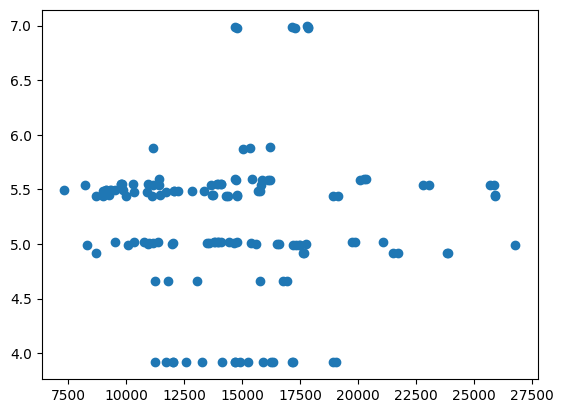

<Figure size 640x480 with 0 Axes>

In [20]:
classicgeometry = pd.merge(areadf[['ID', 'AreaInSquaredPixels']], mass[['ID', 'AverageMass']], on='ID', how='inner')

classicgeometry = pd.merge(classicgeometry[['ID', 'AverageMass', 'AreaInSquaredPixels']], roundnessdf[['ID', 'Roundness']], on='ID', how='inner')

#classicgeometry.to_csv('classicgeometryBlueberriesRaw.csv', index = False)

print(classicgeometry.head(15))

plt.scatter(classicgeometry["AreaInSquaredPixels"], classicgeometry["AverageMass"])
plt.show()
plt.clf()


#print(latex_table)

# Hu Moments

In [23]:
hu0 = pd.Series(IDAndH0).to_frame().reset_index()
hu0.columns = ['ID', 'hu0']
hu0['ID'] = hu0['ID'].astype(int)
hu0['hu0'] = hu0['hu0'].astype(float)
hu0 = hu0.sort_values('ID')
hu0 = hu0.reset_index(drop=True)

#print(hu0.head(10))

hu1 = pd.Series(IDAndH1).to_frame().reset_index()
hu1.columns = ['ID', 'hu1']
hu1['ID'] = hu1['ID'].astype(int)
hu1['hu1'] = hu1['hu1'].astype(float)
hu1 = hu1.sort_values('ID')
hu1 = hu1.reset_index(drop=True)

#print(hu1.head(10))

hu2 = pd.Series(IDAndH2).to_frame().reset_index()
hu2.columns = ['ID', 'hu2']
hu2['ID'] = hu2['ID'].astype(int)
hu2['hu2'] = hu2['hu2'].astype(float)
hu2 = hu2.sort_values('ID')
hu2 = hu2.reset_index(drop=True)

#print(hu2.head(10))

hu3 = pd.Series(IDAndH2).to_frame().reset_index()
hu3.columns = ['ID', 'hu3']
hu3['ID'] = hu3['ID'].astype(int)
hu3['hu3'] = hu3['hu3'].astype(float)
hu3 = hu3.sort_values('ID')
hu3 = hu3.reset_index(drop=True)

#print(hu3.head(10))

hu4 = pd.Series(IDAndH4).to_frame().reset_index()
hu4.columns = ['ID', 'hu4']
hu4['ID'] = hu4['ID'].astype(int)
hu4['hu4'] = hu4['hu4'].astype(float)
hu4 = hu4.sort_values('ID')
hu4 = hu4.reset_index(drop=True)

#print(hu4.head(10))


hu5 = pd.Series(IDAndH5).to_frame().reset_index()
hu5.columns = ['ID', 'hu5']
hu5['ID'] = hu5['ID'].astype(int)
hu5['hu5'] = hu5['hu5'].astype(float)
hu5 = hu5.sort_values('ID')
hu5 = hu5.reset_index(drop=True)

#print(hu5.head(10))


hu6 = pd.Series(IDAndH6).to_frame().reset_index()
hu6.columns = ['ID', 'hu6']
hu6['ID'] = hu6['ID'].astype(int)
hu6['hu6'] = hu6['hu6'].astype(float)
hu6 = hu6.sort_values('ID')
hu6 = hu6.reset_index(drop=True)

#print(hu6.head(10))
humoments = pd.merge(hu0[['ID', 'hu0']], mass[['ID', 'AverageMass']], on='ID', how='inner')

humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0']], hu1[['ID', 'hu1']], on='ID', how='inner')

humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1']], hu2[['ID', 'hu2']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2']], hu3[['ID', 'hu3']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3']], hu4[['ID', 'hu4']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4']], hu5[['ID', 'hu5']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5']], hu6[['ID', 'hu6']], on='ID', how='inner')


humoments.to_csv('humomentsBlueberriesRaw.csv', index = False)

humoments.head(5)
#
#0	1	2	3	4	5	6
#469	2.669828	6.950577	10.427229	10.260607	-20.705395	-13.776959	20.819507
#humoments.loc[468]

#print(latex_table)

,ID,AverageMass,hu0,hu1,hu2,hu3,hu4,hu5,hu6
0,21,6.9924,3.077730,8.909260,11.944054,11.944054,25.357529,17.910823,25.327582
1,22,6.9847,2.489005,7.233462,9.826464,9.826464,20.528179,14.155822,20.188483
2,23,6.9830,2.388342,6.587881,9.249015,9.249015,20.887120,14.292015,21.358331
3,24,6.9821,2.400868,6.743719,9.251103,9.251103,20.691517,-14.064054,20.549992
4,25,6.9839,2.509001,7.052720,10.086986,10.086986,-21.384700,14.889579,-21.744515


# Color

In [24]:
meanB = pd.Series(IDAndMeanB).to_frame().reset_index()
meanB.columns = ['ID', 'meanB']
meanB['ID'] = meanB['ID'].astype(int)
meanB['meanB'] = meanB['meanB'].astype(float)
meanB = meanB.sort_values('ID')
meanB = meanB.reset_index(drop=True)

#print(meanB.head(10))

meanG = pd.Series(IDAndMeanG).to_frame().reset_index()
meanG.columns = ['ID', 'meanG']
meanG['ID'] = meanG['ID'].astype(int)
meanG['meanG'] = meanG['meanG'].astype(float)
meanG = meanG.sort_values('ID')
meanG = meanG.reset_index(drop=True)

#print(meanG.head(10))

meanR = pd.Series(IDAndMeanR).to_frame().reset_index()
meanR.columns = ['ID', 'meanR']
meanR['ID'] = meanR['ID'].astype(int)
meanR['meanR'] = meanR['meanR'].astype(float)
meanR = meanR.sort_values('ID')
meanR = meanR.reset_index(drop=True)

#print(meanR.head(10))

meanGray = pd.Series(IDAndMeanGray).to_frame().reset_index()
meanGray.columns = ['ID', 'meangray']
meanGray['ID'] = meanGray['ID'].astype(int)
meanGray['meangray'] = meanGray['meangray'].astype(float)
meanGray = meanGray.sort_values('ID')
meanGray = meanGray.reset_index(drop=True)

#print(meanGray.head(10))

colors = pd.merge(meanB[['ID', 'meanB']], mass[['ID', 'AverageMass']], on='ID', how='inner')

colors = pd.merge(colors[['ID', 'AverageMass','meanB']], meanG[['ID', 'meanG']], on='ID', how='inner')
colors = pd.merge(colors[['ID', 'AverageMass','meanB', 'meanG']], meanR[['ID', 'meanR']], on='ID', how='inner')
#colors = pd.merge(colors[['ID', 'AverageMass','meanB', 'meanG', 'meanR']], meanGray[['ID', 'meangray']], on='ID', how='inner')

colors.to_csv('colorsBlueberriesRaw.csv', index = False)


colors.head(5)

#print(latex_table)

,ID,AverageMass,meanB,meanG,meanR
0,21,6.9924,198.893786,199.678142,182.305782
1,22,6.9847,54.970148,54.612693,44.816905
2,23,6.9830,45.100719,45.599115,35.627117
3,24,6.9821,47.224629,45.964424,35.895154
4,25,6.9839,59.881441,58.114251,44.982997


(140, 140, 3)


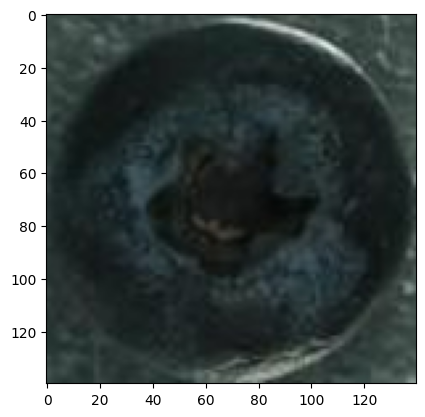

,ID,AverageMass,img
0,21,6.9924,"[[[225, 230, 209], [223, 228, 207], [220, 225,..."
1,22,6.9847,"[[[83, 86, 70], [78, 81, 65], [66, 69, 53], [6..."
2,23,6.9830,"[[[97, 103, 84], [95, 101, 82], [86, 92, 73], ..."
3,24,6.9821,"[[[78, 81, 66], [82, 85, 70], [91, 94, 79], [8..."
4,25,6.9839,"[[[88, 93, 78], [82, 87, 72], [85, 90, 75], [9..."


In [41]:
#print(IDAndSquare)


croppedimages = pd.Series(IDAndSquare).to_frame().reset_index()
croppedimages.columns = ['ID', 'img']
croppedimages['ID'] = croppedimages['ID'].astype(int)

#croppedimages['img'] = croppedimages['img'].astype(float)


croppedimages = croppedimages.sort_values('ID')
croppedimages = croppedimages.reset_index(drop=True)

croppedimages.head(10)

#croppedimages.to_csv('croppedimagesBlueberriesRaw.csv', index = False)

###
%matplotlib inline 


crop = croppedimages.loc[50].at["img"][...,::-1]
#res = cv2.resize(crop, dsize=(140, 140), interpolation=cv2.INTER_CUBIC)


print(crop.shape)

plt.imshow(crop)
plt.show()
###


croppedimages = pd.merge(mass[['ID', 'AverageMass']], croppedimages[['ID', 'img']], on='ID', how='inner')

#croppedimages.to_csv('croppedimagesRaspberriesRaw.csv', index = False)

croppedimages.to_pickle('croppedimagesBlueberriesRaw.pkl')

croppedimages.head(5)

#print(latex_table)


# All data

In [25]:

allfeatures = pd.merge(classicgeometry[['ID', 'AverageMass', 'AreaInSquaredPixels', 'Roundness']], humoments[['ID', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6']], on='ID', how='inner')
allfeatures = pd.merge(allfeatures[['ID', 'AverageMass', 'AreaInSquaredPixels', 'Roundness', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6']], colors[['ID', 'meanB', 'meanG', 'meanR']], on='ID', how='inner')


allfeatures.to_csv('allfeaturesBlueberriesRaw.csv', index = False)

allfeatures.head(5)

,ID,AverageMass,AreaInSquaredPixels,Roundness,hu0,hu1,hu2,hu3,hu4,hu5,hu6,meanB,meanG,meanR
0,21,6.9924,17784.0,0.7531,3.077730,8.909260,11.944054,11.944054,25.357529,17.910823,25.327582,198.893786,199.678142,182.305782
1,22,6.9847,17844.0,0.7737,2.489005,7.233462,9.826464,9.826464,20.528179,14.155822,20.188483,54.970148,54.612693,44.816905
2,23,6.9830,17824.5,0.8063,2.388342,6.587881,9.249015,9.249015,20.887120,14.292015,21.358331,45.100719,45.599115,35.627117
3,24,6.9821,17287.5,0.7483,2.400868,6.743719,9.251103,9.251103,20.691517,-14.064054,20.549992,47.224629,45.964424,35.895154
4,25,6.9839,17164.0,0.7635,2.509001,7.052720,10.086986,10.086986,-21.384700,14.889579,-21.744515,59.881441,58.114251,44.982997
